In [2]:
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
from anndata import AnnData
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:

DATA_PATH = scdrs.__path__[0]
H5AD_FILE = os.path.join(DATA_PATH, "data/toydata_mouse.h5ad")
COV_FILE = os.path.join(DATA_PATH, "data/toydata_mouse.cov")
GS_FILE = os.path.join(DATA_PATH, "data/toydata_mouse.gs")

# Load .h5ad file, .cov file, and .gs file
adata = scdrs.util.load_h5ad(H5AD_FILE, flag_filter_data=False, flag_raw_count=False)
df_cov = pd.read_csv(COV_FILE, sep="\t", index_col=0)
df_gs = scdrs.util.load_gs(GS_FILE)

# Preproecssing .h5ad data compute scDRS score
scdrs.preprocess(adata, cov=df_cov)
gene_list = df_gs['toydata_gs_mouse'][0]
gene_weight = df_gs['toydata_gs_mouse'][1]
df_res = scdrs.score_cell(adata, gene_list, gene_weight=gene_weight, n_ctrl=20)

Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=15


Computing control scores: 100%|██████████| 20/20 [00:00<00:00, 250.38it/s]


In [3]:
print(df_res.iloc[:4])

                                       raw_score  norm_score   mc_pval  \
index                                                                    
N1.MAA000586.3_8_M.1.1-1-1              4.741197    6.326006  0.047619   
F10.D041911.3_8_M.1.1-1-1               4.739066    5.916272  0.047619   
A17_B002755_B007347_S17.mm10-plus-7-0   4.636626    5.552316  0.047619   
C22_B003856_S298_L004.mus-2-0-1         4.680566    7.298668  0.047619   

                                           pval  nlog10_pval    zscore  
index                                                                   
N1.MAA000586.3_8_M.1.1-1-1             0.001664     2.778874  2.935716  
F10.D041911.3_8_M.1.1-1-1              0.001664     2.778874  2.935716  
A17_B002755_B007347_S17.mm10-plus-7-0  0.001664     2.778874  2.935716  
C22_B003856_S298_L004.mus-2-0-1        0.001664     2.778874  2.935716  


In [3]:
os.chdir("/home/lfzhang/SingleCell/py/scDRS")

In [4]:
adata = sc.read_h5ad("anndata.h5ad")

In [52]:


#!scdrs compute-score \
    --h5ad_file anndata.h5ad\
    --h5ad_species human\
    --gs-file processed_geneset.gs\
    --gs-species human\
    --flag-filter-data True\
    --flag-raw-count True\
    --n-ctrl 1000\
    --flag-return-ctrl-raw-score False\
    --flag-return-ctrl-norm-score True\
    --out_folder /home/lfzhang/SingleCell/py/scDRS/results

******************************************************************************
* Single-cell disease relevance score (scDRS)
* Version 1.0.2
* Martin Jinye Zhang and Kangcheng Hou
* HSPH / Broad Institute / UCLA
* MIT License
******************************************************************************
Call: scdrs compute-score \
--h5ad-file anndata.h5ad \
--h5ad-species human \
--cov-file None \
--gs-file processed_geneset.gs \
--gs-species human \
--ctrl-match-opt mean_var \
--weight-opt vs \
--adj-prop None \
--flag-filter-data True \
--flag-raw-count True \
--n-ctrl 1000 \
--flag-return-ctrl-raw-score False \
--flag-return-ctrl-norm-score True \
--out-folder /home/lfzhang/SingleCell/py/scDRS/results

Loading data:
--h5ad-file loaded: n_cell=136602, n_gene=27041 (sys_time=419.1s)
First 3 cells: ['F1.AAACCCACACCTCTGT-1.Mic.Mic1', 'F1.AAACCCATCGGCATTA-1.ExN.ExN7', 'F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix']
First 5 genes: ['AL627309.1', 'AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115']


In [5]:
df_gs = pd.read_csv("processed_geneset.gs", sep="\t", index_col=0)
print(df_gs.index)

Index(['MDD', 'AD', 'Height'], dtype='object', name='TRAIT')


In [6]:
dict_score = {
    trait: pd.read_csv(f"results/MDD.full_score.gz", sep="\t", index_col=0)
    for trait in df_gs.index
}

In [7]:
for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

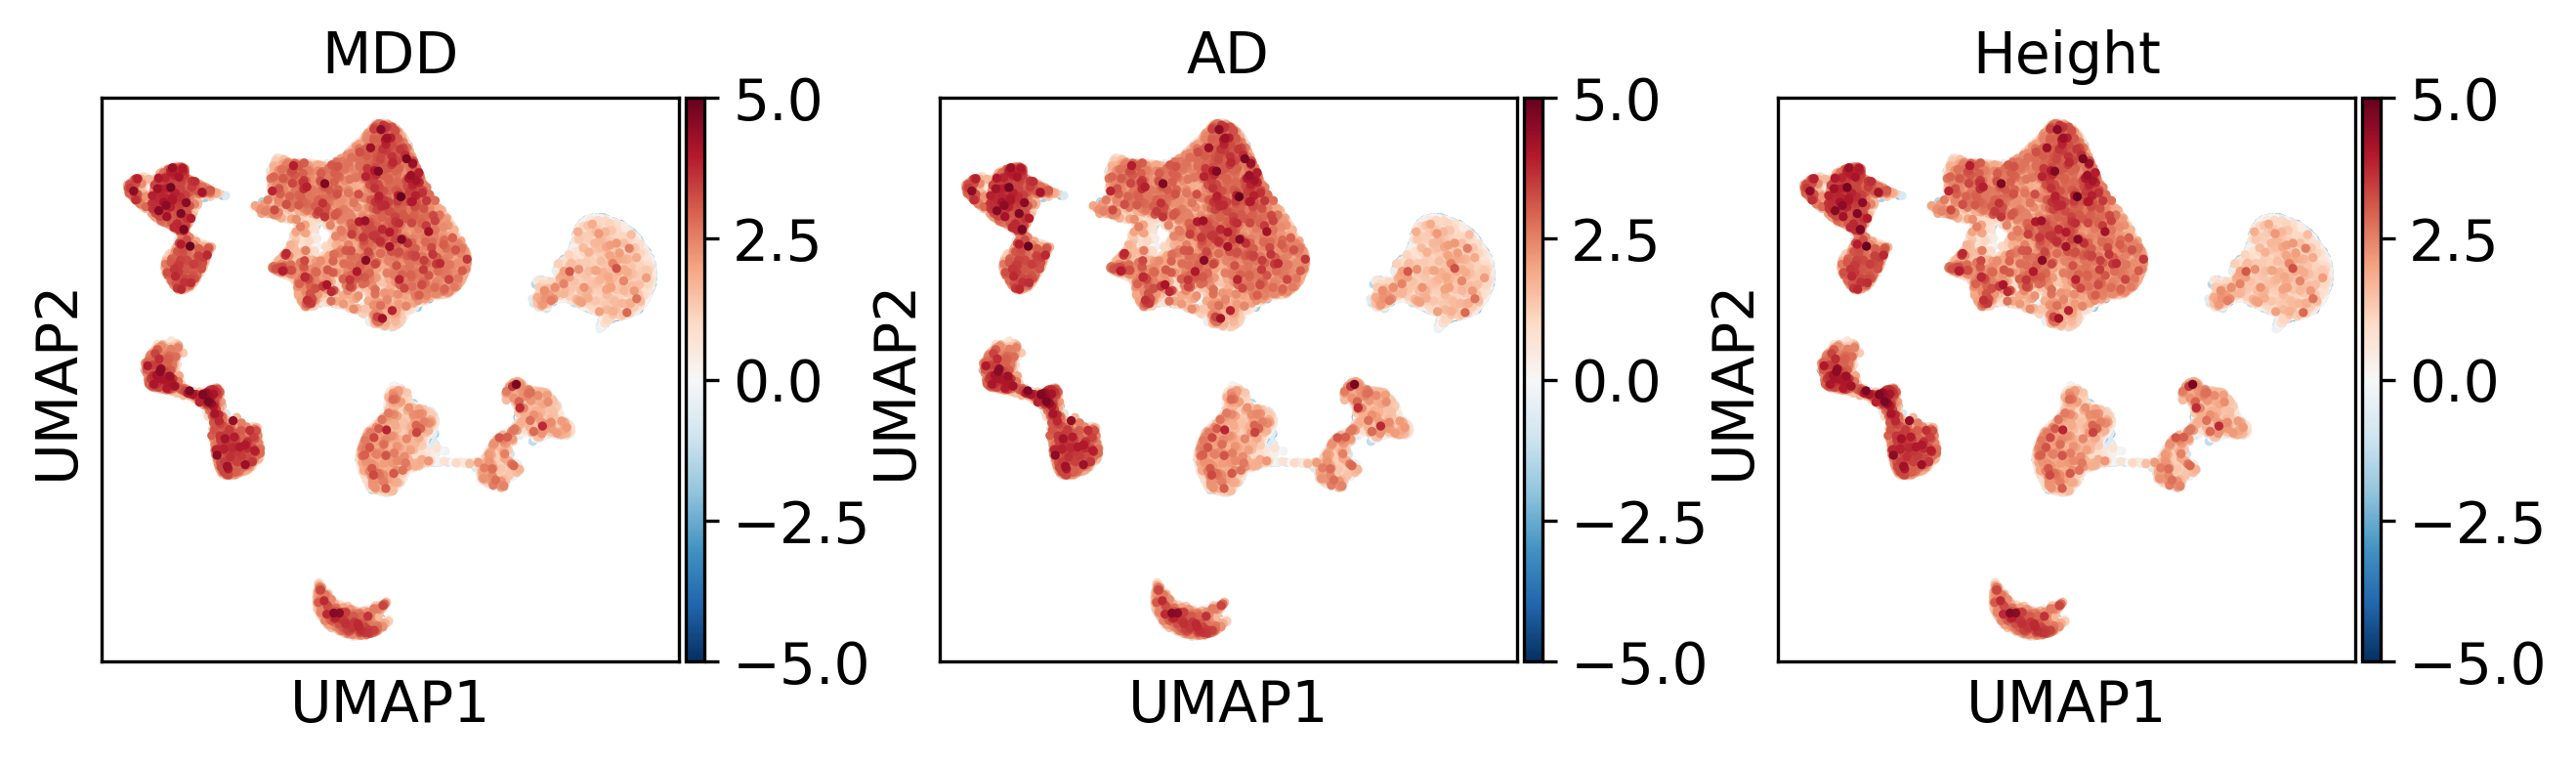

In [13]:
sc.set_figure_params(figsize=[2.5, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
)


In [18]:
for trait, df in dict_score.items():
    print(f"Trait: {trait}")
    print(df.head())

Trait: MDD
                                    raw_score  norm_score   mc_pval      pval  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1       0.145275    0.608507  0.285714  0.266630   
F1.AAACCCATCGGCATTA-1.ExN.ExN7       0.148073    0.009660  0.494505  0.486852   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix   0.180902    1.044982  0.151848  0.148409   
F1.AAACGAATCGGAATGG-1.Oli.Oli3       0.131988    0.235355  0.401598  0.398505   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1       0.085715    0.680181  0.247752  0.244287   

                                    nlog10_pval    zscore  ctrl_norm_score_0  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1         0.574091  0.623038           1.606273   
F1.AAACCCATCGGCATTA-1.ExN.ExN7         0.312603  0.032964           0.674903   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix     0.828539  1.043281          -1.277963   
F1.AAACGAATCGGAATGG-1.Oli.Oli3         0.399566  0.257217          -1.699058   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1         0.612100  0.692579           1.127015   

                     

In [19]:
print(adata.obs.head())

                                   batch chem  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1        8F   v3   
F1.AAACCCATCGGCATTA-1.ExN.ExN7        8F   v3   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix    8F   v3   
F1.AAACGAATCGGAATGG-1.Oli.Oli3        8F   v3   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1        8F   v3   

                                   DF.classifications_0.25_0.001_10840 group  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1                                 Singlet  Case   
F1.AAACCCATCGGCATTA-1.ExN.ExN7                                 Singlet  Case   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix                             Singlet  Case   
F1.AAACGAATCGGAATGG-1.Oli.Oli3                                 Singlet  Case   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1                                 Singlet  Case   

                                   indiv MainType majority_voting  nCount_RNA  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1        F1    Micro      Astrocytes      2848.0   
F1.AAACCCATCGGCATTA-1.ExN.ExN7        F1       Ex     CA1_neur

In [14]:
for trait in dict_score:
    print(f"Trait: {trait}")
    print(dict_score[trait]["norm_score"].describe())

Trait: MDD
count    1.366020e+05
mean    -4.106984e-11
std      1.151412e+00
min     -4.581633e+00
25%     -8.041997e-01
50%     -2.749467e-02
75%      7.715643e-01
max      5.099695e+00
Name: norm_score, dtype: float64
Trait: AD
count    1.366020e+05
mean     2.021793e-10
std      1.155399e+00
min     -4.810587e+00
25%     -7.953188e-01
50%     -7.346030e-02
75%      7.192573e-01
max      6.347518e+00
Name: norm_score, dtype: float64
Trait: Height
count    1.366020e+05
mean    -7.431296e-11
std      1.175461e+00
min     -4.896394e+00
25%     -7.830348e-01
50%      1.024742e-03
75%      7.819030e-01
max      6.330681e+00
Name: norm_score, dtype: float64


In [12]:
dict_score = {
    trait: pd.read_csv(f"results/{trait}.full_score.gz", sep="\t", index_col=0)
    for trait in df_gs.index
}

# 确认每个性状的数据都正确加载
for trait, df in dict_score.items():
    print(f"Trait: {trait}")
    print(df.head())

Trait: MDD
                                    raw_score  norm_score   mc_pval      pval  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1       0.145275    0.608507  0.285714  0.266630   
F1.AAACCCATCGGCATTA-1.ExN.ExN7       0.148073    0.009660  0.494505  0.486852   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix   0.180902    1.044982  0.151848  0.148409   
F1.AAACGAATCGGAATGG-1.Oli.Oli3       0.131988    0.235355  0.401598  0.398505   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1       0.085715    0.680181  0.247752  0.244287   

                                    nlog10_pval    zscore  ctrl_norm_score_0  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1         0.574091  0.623038           1.606273   
F1.AAACCCATCGGCATTA-1.ExN.ExN7         0.312603  0.032964           0.674903   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix     0.828539  1.043281          -1.277963   
F1.AAACGAATCGGAATGG-1.Oli.Oli3         0.399566  0.257217          -1.699058   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1         0.612100  0.692579           1.127015   

                     

In [15]:
for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

sc.set_figure_params(figsize=[4, 4], dpi=150)



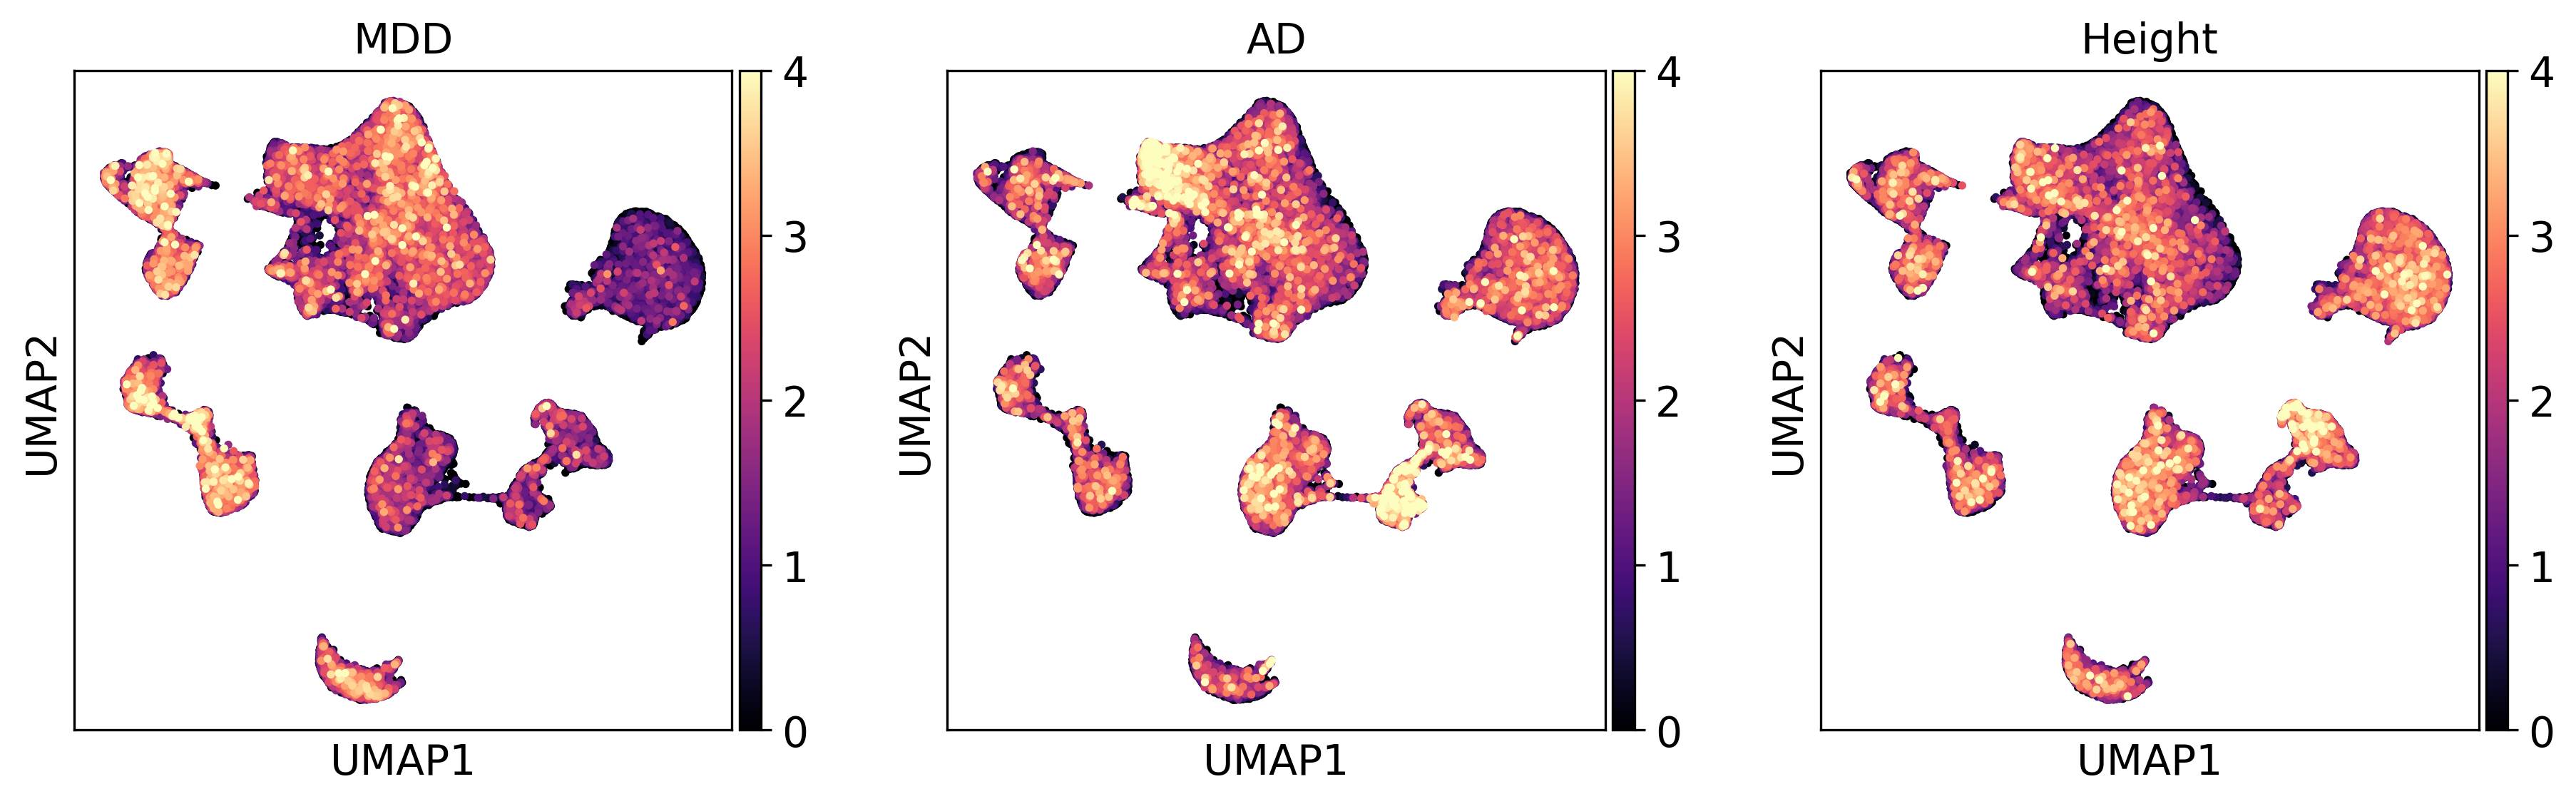

In [30]:
# 绘制UMAP图
sc.pl.umap(
    adata,
    color=list(dict_score.keys()),
    color_map="magma",  # 选择一个不同的颜色映射
    vmin=0,  # 调整颜色范围
    vmax=4,
    s=30,  # 调整点大小
    ncols=3,  # 将性状分别绘制在不同列中
    save="MDD_scDRS.png"
)

Index(['MDD', 'AD', 'Height'], dtype='object', name='TRAIT')
Trait: MDD
                                    raw_score  norm_score   mc_pval      pval  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1       0.145275    0.608507  0.285714  0.266630   
F1.AAACCCATCGGCATTA-1.ExN.ExN7       0.148073    0.009660  0.494505  0.486852   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix   0.180902    1.044982  0.151848  0.148409   
F1.AAACGAATCGGAATGG-1.Oli.Oli3       0.131988    0.235355  0.401598  0.398505   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1       0.085715    0.680181  0.247752  0.244287   

                                    nlog10_pval    zscore  ctrl_norm_score_0  \
F1.AAACCCACACCTCTGT-1.Mic.Mic1         0.574091  0.623038           1.606273   
F1.AAACCCATCGGCATTA-1.ExN.ExN7         0.312603  0.032964           0.674903   
F1.AAACGAATCAGGGTAG-1.InN.InN8_Mix     0.828539  1.043281          -1.277963   
F1.AAACGAATCGGAATGG-1.Oli.Oli3         0.399566  0.257217          -1.699058   
F1.AAACGCTAGGACTTCT-1.Ast.Ast1         0.

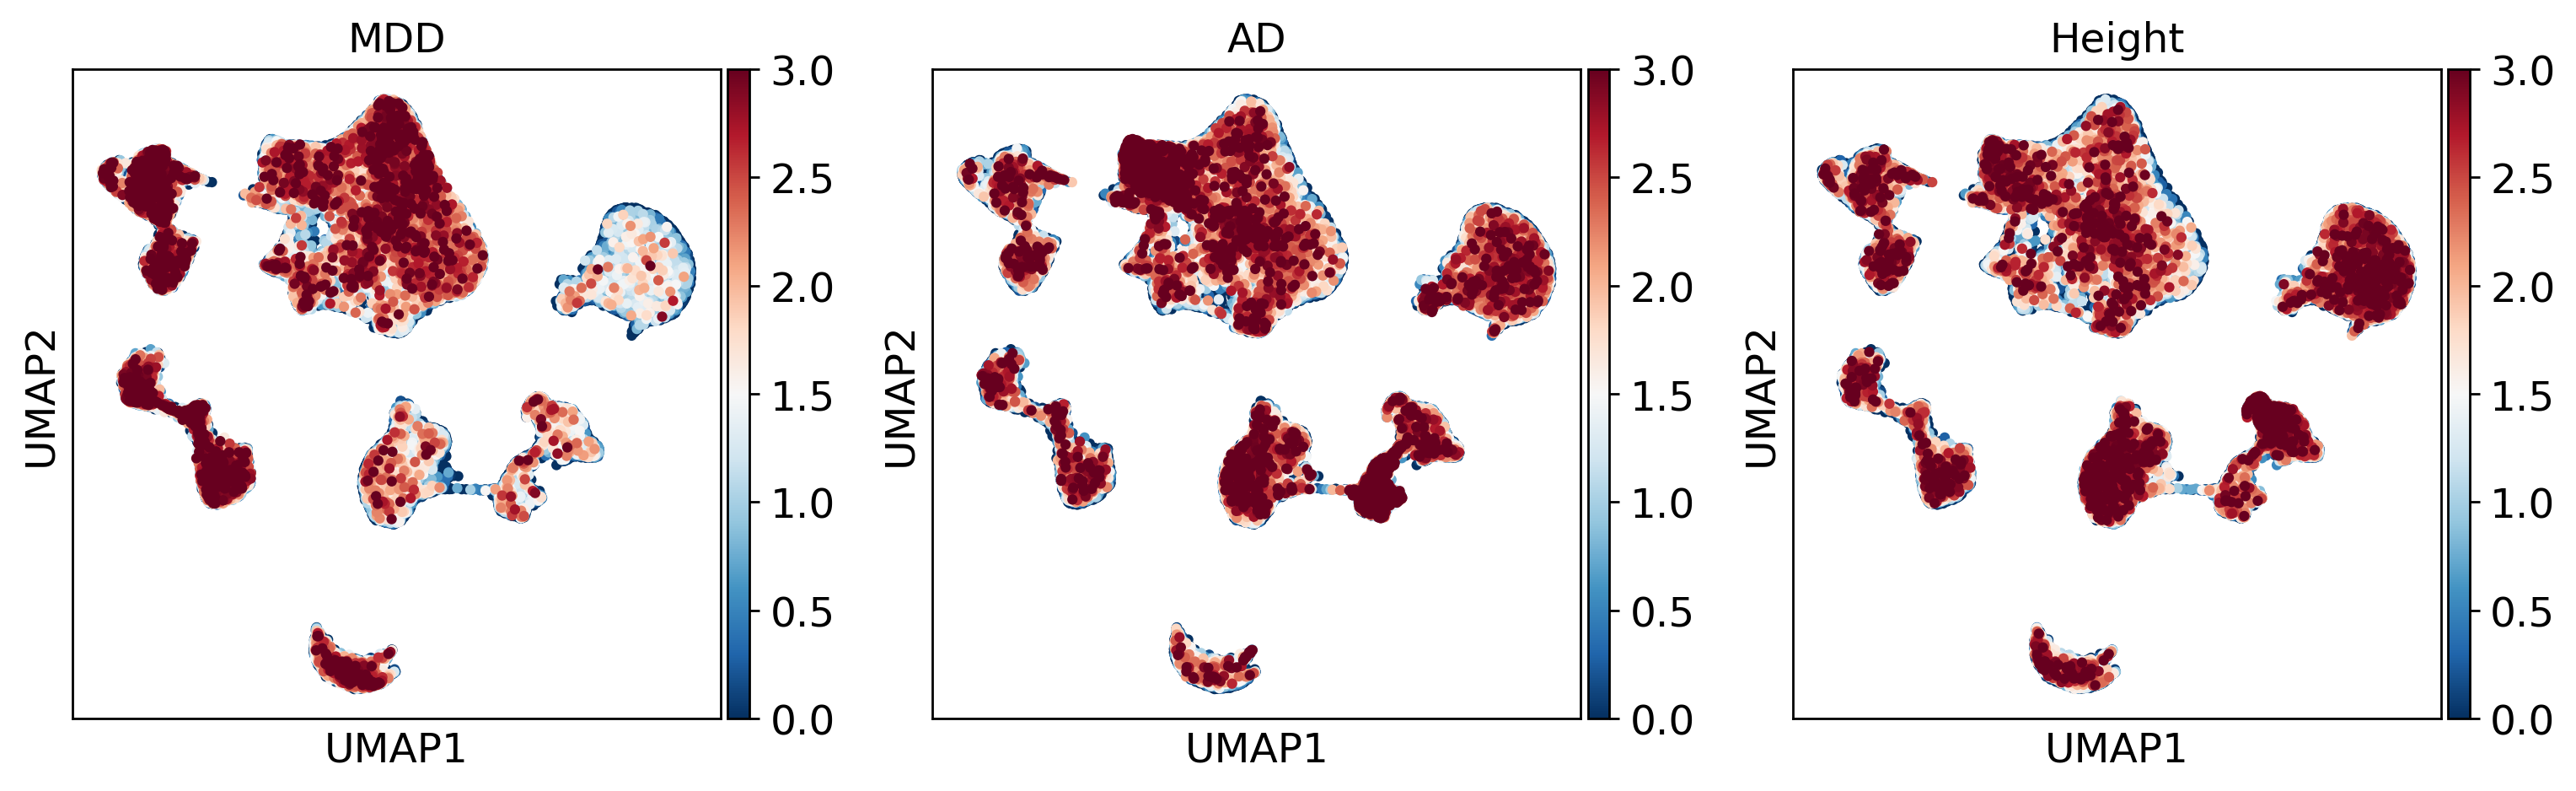

In [31]:
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
from anndata import AnnData
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("/home/lfzhang/SingleCell/py/scDRS")

adata = sc.read_h5ad("anndata.h5ad")
df_gs = pd.read_csv("processed_geneset.gs", sep="\t", index_col=0)
print(df_gs.index)   
dict_score = {
    trait: pd.read_csv(f"results/{trait}.full_score.gz", sep="\t", index_col=0)
    for trait in df_gs.index
}
# 确认每个性状的数据都正确加载
for trait, df in dict_score.items():
    print(f"Trait: {trait}")
    print(df.head())
for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]
# 绘制UMAP图
sc.pl.umap(
    adata,
    color=list(dict_score.keys()),
    color_map="magma",  # 选择一个不同的颜色映射
    vmin=0,  # 调整颜色范围
    vmax=3,
    s=50,  # 调整点大小
    ncols=3,  # 将性状分别绘制在不同列中
#   save="MDD_scDRS.png"
)